# Fine-Tuning FLUX.2 Klein Base with LoRA
## From Theory to Practice

**Workshop Overview**

Today we'll cover:
1. **Klein Base Architecture** — What makes it different
2. **LoRA Mechanics** — How parameter-efficient fine-tuning works
3. **Live Demo** — Real training run on "Pimp My Ride" car transformation
4. **Practical Insights** — What we learned, what to watch for

We assume you're familiar with diffusion models and have used LoRA before. We'll focus on the *why* and *what we observed*, not the basics.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize': (14, 6), 'font.size': 11})

# Colors
C = {
    'frozen': '#4a5568', 'lora': '#e53e3e', 'good': '#22c55e',
    'warn': '#eab308', 'info': '#38bdf8', 'double': '#8b5cf6', 'single': '#06b6d4'
}

# Path to our demo samples
SAMPLES_DIR = Path('samples')

print('Ready')

Ready


---
# Part 1: Klein Base Architecture

## Why Klein Base for Fine-Tuning?

Klein Base is **undistilled** — it hasn't been compressed for faster inference. This matters for fine-tuning:

| Model | Distilled? | Fine-tuning Quality | Inference Speed |
|-------|-----------|--------------------|-----------------|
| Klein Base 4B | No | Better | Slower |
| Schnell | Yes | Worse | Faster |

Distillation trades away some of the model's capacity for speed. For fine-tuning, we want that capacity.

## Flow Matching vs DDPM

Klein Base uses **flow matching**, not DDPM. Key differences:

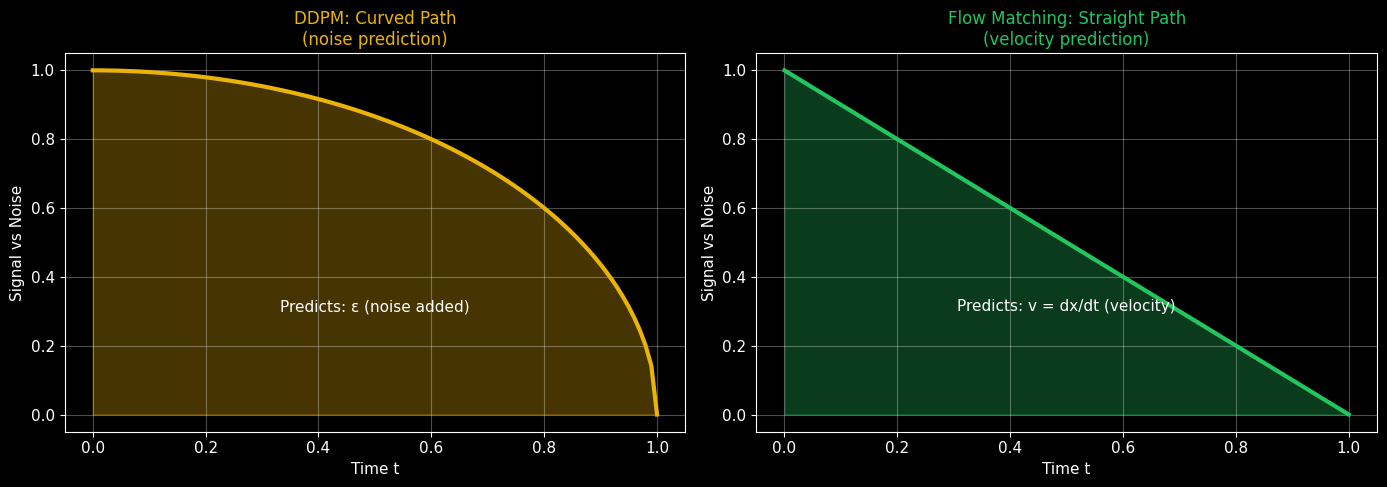

Practical implications for fine-tuning:
  • No SNR weighting tricks needed
  • Uniform timestep sampling works well
  • Generally more stable training


In [2]:
def show_flow_vs_ddpm():
    """Visualize the key difference between flow matching and DDPM."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    t = np.linspace(0, 1, 100)
    
    # DDPM: curved path through noise levels
    ax1 = axes[0]
    ddpm_path = np.sqrt(1 - t**2)  # Simplified visualization
    ax1.plot(t, ddpm_path, color=C['warn'], lw=3)
    ax1.fill_between(t, ddpm_path, alpha=0.3, color=C['warn'])
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Signal vs Noise')
    ax1.set_title('DDPM: Curved Path\n(noise prediction)', fontsize=12, color=C['warn'])
    ax1.text(0.5, 0.3, 'Predicts: ε (noise added)', ha='center', fontsize=11, color='white')
    ax1.grid(True, alpha=0.3)
    
    # Flow matching: straight path
    ax2 = axes[1]
    flow_path = 1 - t  # Linear interpolation
    ax2.plot(t, flow_path, color=C['good'], lw=3)
    ax2.fill_between(t, flow_path, alpha=0.3, color=C['good'])
    ax2.set_xlabel('Time t')
    ax2.set_ylabel('Signal vs Noise')
    ax2.set_title('Flow Matching: Straight Path\n(velocity prediction)', fontsize=12, color=C['good'])
    ax2.text(0.5, 0.3, 'Predicts: v = dx/dt (velocity)', ha='center', fontsize=11, color='white')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Practical implications for fine-tuning:")
    print("  • No SNR weighting tricks needed")
    print("  • Uniform timestep sampling works well")
    print("  • Generally more stable training")

show_flow_vs_ddpm()

## Dual-Stream Transformer Architecture

Klein Base has two types of transformer blocks:

- **Double-stream blocks (5)**: Image and text processed separately, then cross-attend
- **Single-stream blocks (20)**: Concatenated image+text processed jointly

This matters for LoRA because *where* you apply LoRA affects *what* gets learned.

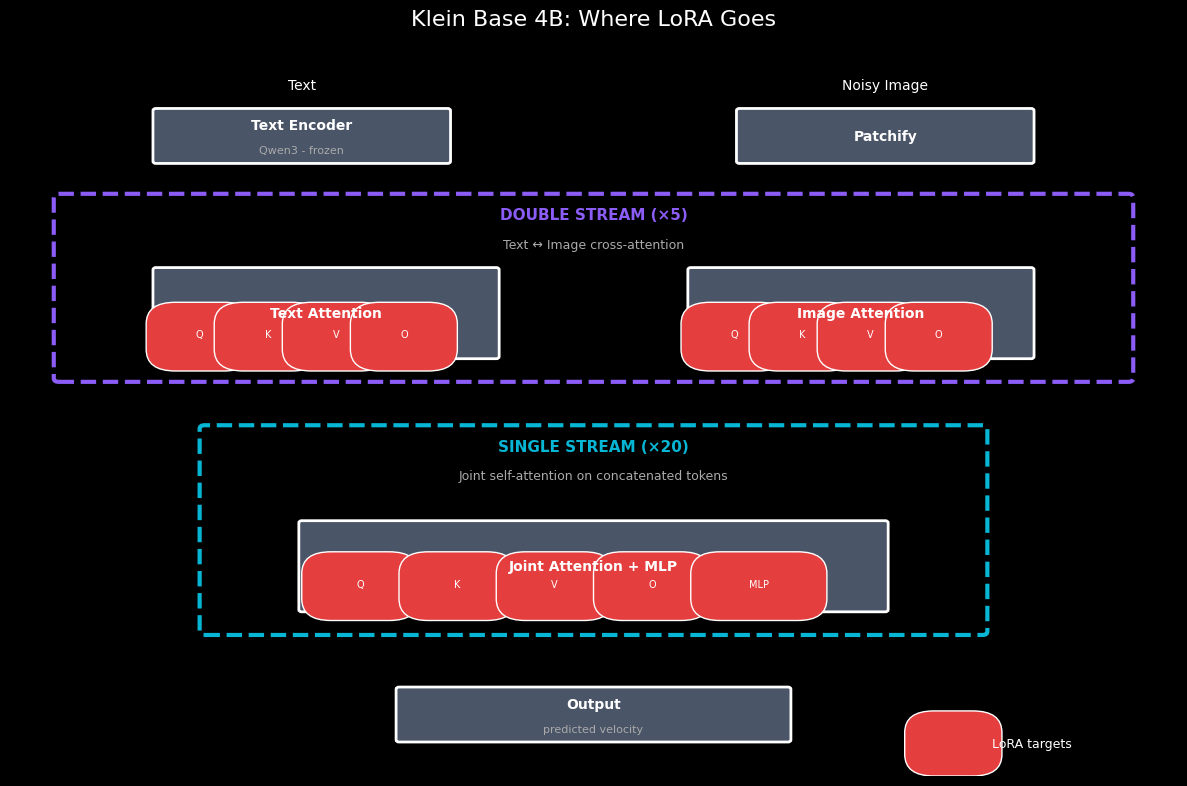


Klein Base 4B specs:
  • Hidden dim: 3072
  • Attention heads: 24
  • Double stream: 5 blocks
  • Single stream: 20 blocks
  • Total params: ~4B


In [3]:
def show_architecture():
    """Klein Base 4B architecture overview."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('Klein Base 4B: Where LoRA Goes', fontsize=16, pad=20)
    
    def box(x, y, w, h, label, color, sub=None):
        ax.add_patch(FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.03",
                                     facecolor=color, edgecolor='white', lw=2))
        ax.text(x+w/2, y+h/2+(0.15 if sub else 0), label, ha='center', va='center',
               fontsize=10, color='white', fontweight='bold')
        if sub:
            ax.text(x+w/2, y+h/2-0.2, sub, ha='center', va='center', fontsize=8, color='#aaa')
    
    # Text + Image inputs
    ax.text(3, 9.5, 'Text', ha='center', fontsize=10, color='white')
    ax.text(9, 9.5, 'Noisy Image', ha='center', fontsize=10, color='white')
    
    # Encoders
    box(1.5, 8.5, 3, 0.7, 'Text Encoder', C['frozen'], 'Qwen3 - frozen')
    box(7.5, 8.5, 3, 0.7, 'Patchify', C['frozen'])
    
    # Double stream
    ax.add_patch(FancyBboxPatch((0.5, 5.5), 11, 2.5, boxstyle="round,pad=0.05",
                                 facecolor='none', edgecolor=C['double'], lw=3, ls='--'))
    ax.text(6, 7.7, 'DOUBLE STREAM (×5)', ha='center', fontsize=11, color=C['double'], fontweight='bold')
    ax.text(6, 7.3, 'Text ↔ Image cross-attention', ha='center', fontsize=9, color='#aaa')
    
    box(1.5, 5.8, 3.5, 1.2, 'Text Attention', C['frozen'])
    box(7, 5.8, 3.5, 1.2, 'Image Attention', C['frozen'])
    
    # LoRA markers
    for x_base in [1.7, 7.2]:
        for i, l in enumerate(['Q', 'K', 'V', 'O']):
            ax.add_patch(FancyBboxPatch((x_base + i*0.7, 5.9), 0.5, 0.35,
                                         boxstyle="round", facecolor=C['lora'], edgecolor='white', lw=1))
            ax.text(x_base + i*0.7 + 0.25, 6.07, l, ha='center', fontsize=7, color='white')
    
    # Single stream
    ax.add_patch(FancyBboxPatch((2, 2), 8, 2.8, boxstyle="round,pad=0.05",
                                 facecolor='none', edgecolor=C['single'], lw=3, ls='--'))
    ax.text(6, 4.5, 'SINGLE STREAM (×20)', ha='center', fontsize=11, color=C['single'], fontweight='bold')
    ax.text(6, 4.1, 'Joint self-attention on concatenated tokens', ha='center', fontsize=9, color='#aaa')
    
    box(3, 2.3, 6, 1.2, 'Joint Attention + MLP', C['frozen'])
    for i, l in enumerate(['Q', 'K', 'V', 'O', 'MLP']):
        w = 0.6 if l != 'MLP' else 0.8
        ax.add_patch(FancyBboxPatch((3.3 + i*1.0, 2.45), w, 0.35,
                                     boxstyle="round", facecolor=C['lora'], edgecolor='white', lw=1))
        ax.text(3.3 + i*1.0 + w/2, 2.62, l, ha='center', fontsize=7, color='white')
    
    # Output
    box(4, 0.5, 4, 0.7, 'Output', C['frozen'], 'predicted velocity')
    
    # Legend
    ax.add_patch(FancyBboxPatch((9.5, 0.3), 0.4, 0.3, facecolor=C['lora'], edgecolor='white'))
    ax.text(10.1, 0.45, 'LoRA targets', fontsize=9, color='white', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nKlein Base 4B specs:")
    print("  • Hidden dim: 3072")
    print("  • Attention heads: 24")
    print("  • Double stream: 5 blocks")
    print("  • Single stream: 20 blocks")
    print("  • Total params: ~4B")

show_architecture()

---
# Part 2: LoRA Mechanics

## The Core Idea

Instead of updating the full weight matrix W, we add a low-rank decomposition:

```
W' = W + ΔW = W + BA
```

Where:
- W is the original frozen weight (e.g., 3072 × 3072)
- B is a small matrix (3072 × rank)
- A is a small matrix (rank × 3072)
- rank is typically 8-64

**Why this works:** Fine-tuning updates tend to be low-rank — you're teaching *one specific thing*, not rewriting the whole model.

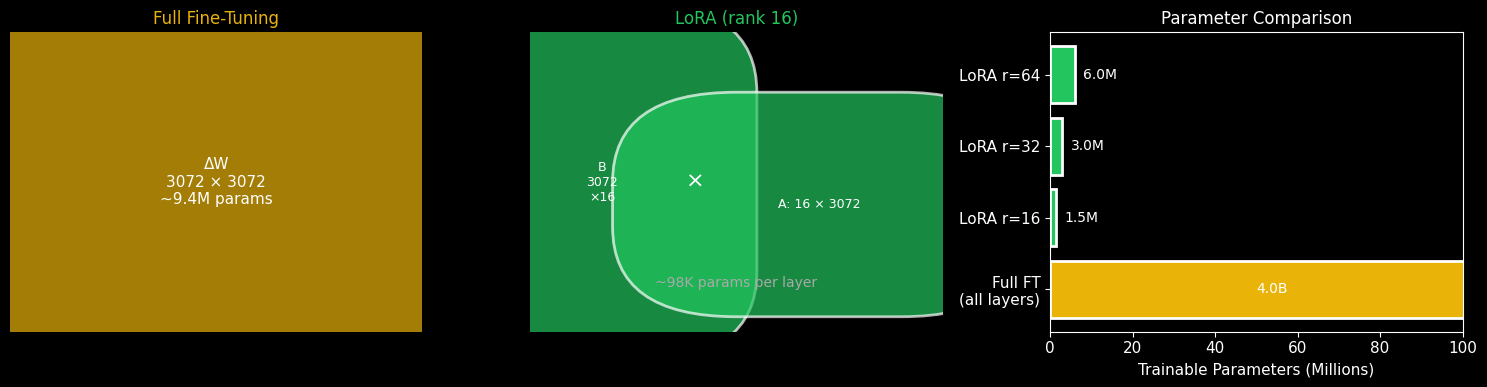

In [4]:
def visualize_lora_math():
    """Visualize the LoRA decomposition."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Full fine-tuning
    ax1 = axes[0]
    ax1.set_title('Full Fine-Tuning', fontsize=12, color=C['warn'])
    ax1.add_patch(FancyBboxPatch((0.1, 0.1), 0.8, 0.8, facecolor=C['warn'], alpha=0.7,
                                  edgecolor='white', lw=2, transform=ax1.transAxes))
    ax1.text(0.5, 0.5, 'ΔW\n3072 × 3072\n~9.4M params', ha='center', va='center',
            fontsize=11, color='white', transform=ax1.transAxes)
    ax1.axis('off')
    
    # LoRA
    ax2 = axes[1]
    ax2.set_title('LoRA (rank 16)', fontsize=12, color=C['good'])
    ax2.add_patch(FancyBboxPatch((0.1, 0.2), 0.15, 0.6, facecolor=C['good'], alpha=0.7,
                                  edgecolor='white', lw=2, transform=ax2.transAxes))
    ax2.text(0.175, 0.5, 'B\n3072\n×16', ha='center', va='center',
            fontsize=9, color='white', transform=ax2.transAxes)
    ax2.text(0.4, 0.5, '×', ha='center', va='center', fontsize=16, color='white', transform=ax2.transAxes)
    ax2.add_patch(FancyBboxPatch((0.5, 0.35), 0.4, 0.15, facecolor=C['good'], alpha=0.7,
                                  edgecolor='white', lw=2, transform=ax2.transAxes))
    ax2.text(0.7, 0.425, 'A: 16 × 3072', ha='center', va='center',
            fontsize=9, color='white', transform=ax2.transAxes)
    ax2.text(0.5, 0.15, '~98K params per layer', ha='center', fontsize=10, color='#aaa', transform=ax2.transAxes)
    ax2.axis('off')
    
    # Comparison
    ax3 = axes[2]
    ax3.set_title('Parameter Comparison', fontsize=12)
    methods = ['Full FT\n(all layers)', 'LoRA r=16', 'LoRA r=32', 'LoRA r=64']
    params = [4000, 1.5, 3.0, 6.0]  # Millions
    colors = [C['warn'], C['good'], C['good'], C['good']]
    bars = ax3.barh(methods, params, color=colors, edgecolor='white', lw=2)
    ax3.set_xlabel('Trainable Parameters (Millions)')
    ax3.set_xlim(0, 100)
    for bar, p in zip(bars, params):
        if p > 100:
            ax3.text(50, bar.get_y() + bar.get_height()/2, f'{p/1000:.1f}B', va='center', fontsize=10)
        else:
            ax3.text(p + 2, bar.get_y() + bar.get_height()/2, f'{p:.1f}M', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

visualize_lora_math()

## Key Hyperparameters

| Parameter | What it controls | Typical range |
|-----------|-----------------|---------------|
| **rank** | Capacity to learn | 8-64 |
| **alpha** | Scaling factor | Usually = rank |
| **lr** | Learning speed | 1e-4 to 3e-4 |
| **steps** | Training duration | 250-1500 |

The effective LoRA strength is `alpha / rank`. When alpha = rank, the scaling is 1.0.

---
# Part 3: Live Demo — Pimp My Ride

## The Task

We trained a LoRA to transform regular cars into "pimped" versions with:
- Wide body kits
- Custom wheels
- Vibrant paint
- Racing modifications

## Training Configuration

```yaml
model: FLUX.2-Klein-Base-4B
rank: 32
alpha: 32
learning_rate: 1e-4
steps: 500
batch_size: 1
dataset: 44 image pairs (reference → target)
```

## Dataset Examples

The training data consists of before/after pairs:

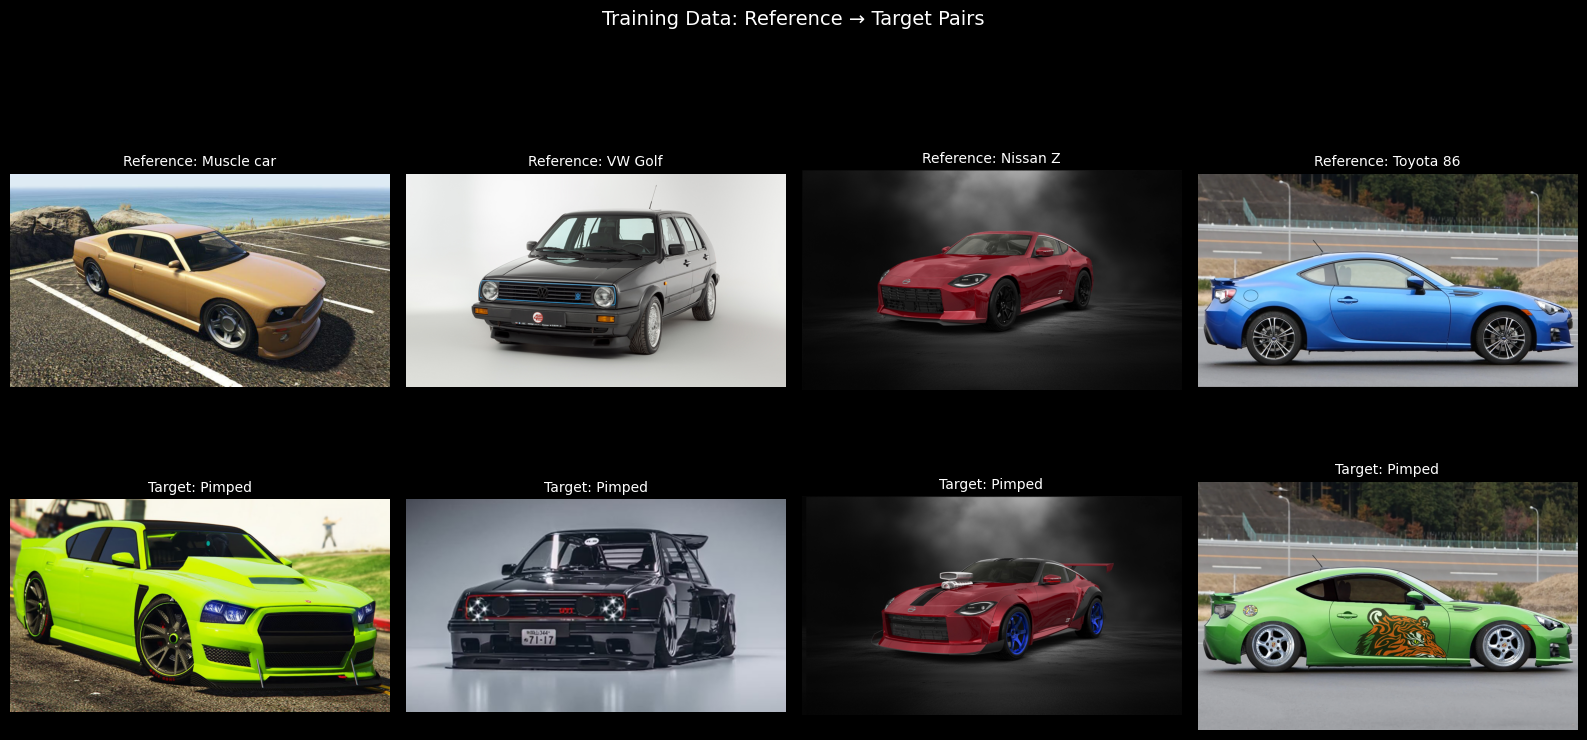

Dataset stats:
  • 44 training pairs
  • 3 held out for testing
  • Varied car types: sports, muscle, hatchbacks, trucks, SUVs
  • Unique captions per image describing mods


In [5]:
def show_dataset_examples():
    """Show example training pairs."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # We'll use placeholder for the actual training images
    # In real workshop, load from training_data folder
    
    training_data = Path('training_data')
    
    pairs = [('001', 'Muscle car'), ('003', 'VW Golf'), ('006', 'Nissan Z'), ('012', 'Toyota 86')]
    
    for i, (idx, label) in enumerate(pairs):
        # Reference (before)
        ref_path = training_data / 'pimpmyride_control' / f'{idx}.png'
        if ref_path.exists():
            img = Image.open(ref_path)
            axes[0, i].imshow(img)
        axes[0, i].set_title(f'Reference: {label}', fontsize=10)
        axes[0, i].axis('off')
        
        # Target (after)
        tgt_path = training_data / 'pimpmyride' / f'{idx}.png'
        if tgt_path.exists():
            img = Image.open(tgt_path)
            axes[1, i].imshow(img)
        axes[1, i].set_title('Target: Pimped', fontsize=10)
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Before', fontsize=12, rotation=0, ha='right', va='center')
    axes[1, 0].set_ylabel('After', fontsize=12, rotation=0, ha='right', va='center')
    
    plt.suptitle('Training Data: Reference → Target Pairs', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("Dataset stats:")
    print("  • 44 training pairs")
    print("  • 3 held out for testing")
    print("  • Varied car types: sports, muscle, hatchbacks, trucks, SUVs")
    print("  • Unique captions per image describing mods")

show_dataset_examples()

## Training Progression

Let's see how the model learned over 500 steps.

These samples were generated during training using the prompt: `"pimpmyride, a sports car"`

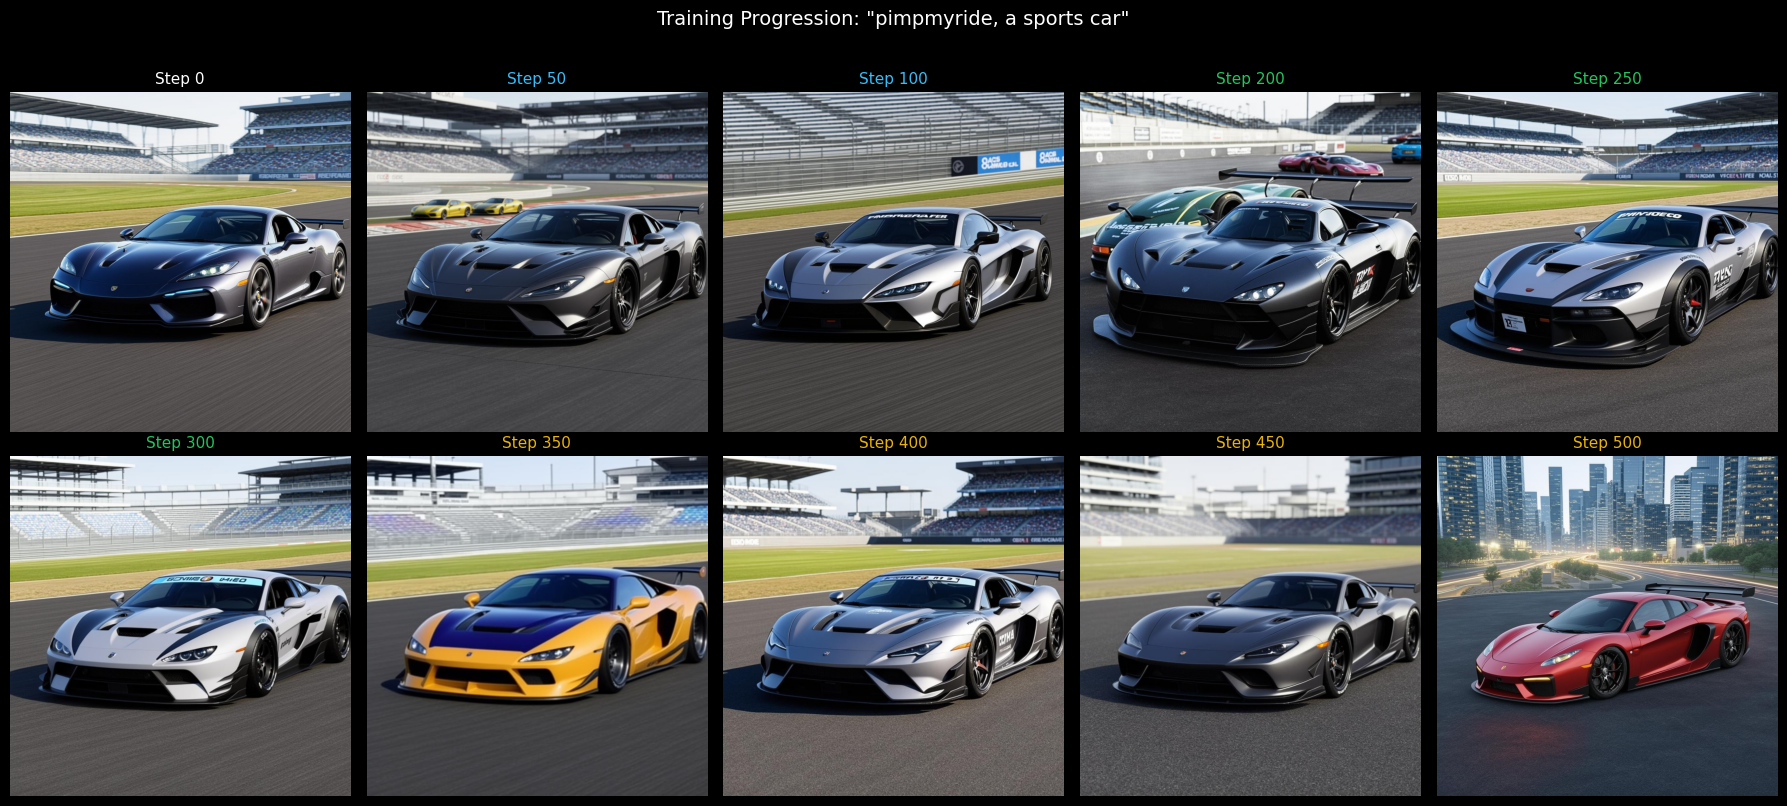

In [6]:
def show_training_progression():
    """Display samples from different training steps."""
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    
    steps = [0, 50, 100, 200, 250, 300, 350, 400, 450, 500]
    
    # Map step to filename (prompt 0)
    step_files = {
        0: '1768946967141__000000000_0.jpg',
        50: '1768947077803__000000050_0.jpg',
        100: '1768947186514__000000100_0.jpg',
        200: '1768947404491__000000200_0.jpg',
        250: '1768947514157__000000250_0.jpg',
        300: '1768947621817__000000300_0.jpg',
        350: '1768947732234__000000350_0.jpg',
        400: '1768947841399__000000400_0.jpg',
        450: '1768947950571__000000450_0.jpg',
        500: '1768948054553__000000500_0.jpg',
    }
    
    samples_dir = Path('samples')
    
    for i, step in enumerate(steps):
        row, col = i // 5, i % 5
        ax = axes[row, col]
        
        img_path = samples_dir / step_files[step]
        if img_path.exists():
            img = Image.open(img_path)
            ax.imshow(img)
        
        # Color code by training phase
        if step == 0:
            color = 'white'
            phase = 'baseline'
        elif step <= 100:
            color = C['info']
            phase = 'early'
        elif step <= 300:
            color = C['good']
            phase = 'learning'
        else:
            color = C['warn']
            phase = 'converging'
        
        ax.set_title(f'Step {step}', fontsize=11, color=color)
        ax.axis('off')
    
    plt.suptitle('Training Progression: "pimpmyride, a sports car"', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

show_training_progression()

## Loss Curve Analysis

Here's what we observed during training:

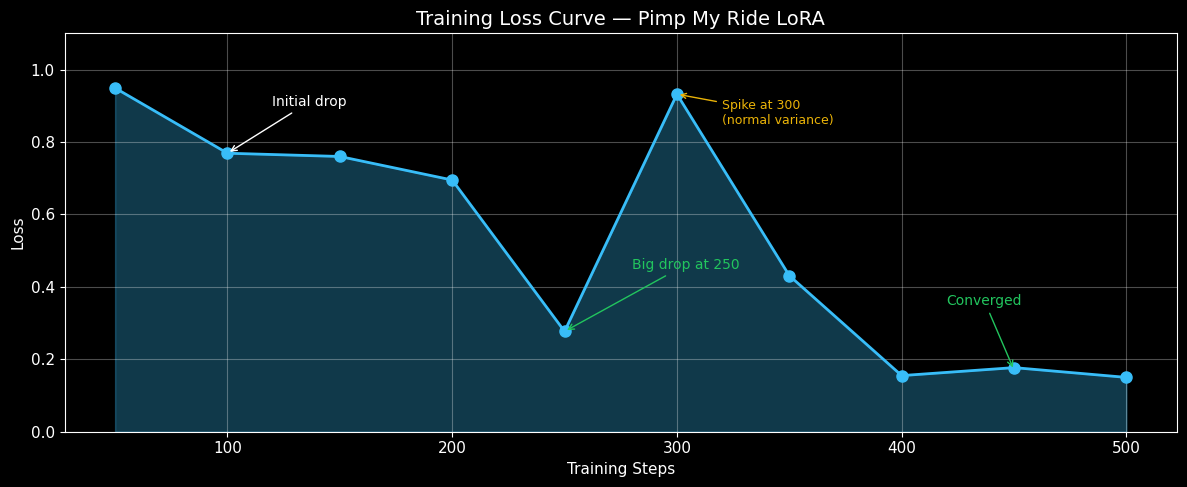

Observations:
  • Sharp drop in first 100 steps — model quickly picks up the concept
  • Major improvement around step 250 — concept solidifying
  • Loss spikes are normal with small batch size (variance)
  • Converges around 400-500 steps


In [7]:
def show_loss_curve():
    """Visualize the training loss curve."""
    # Actual loss values from training run
    steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    losses = [0.949, 0.769, 0.760, 0.695, 0.277, 0.932, 0.431, 0.155, 0.177, 0.15]  # Approximate
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(steps, losses, 'o-', color=C['info'], lw=2, markersize=8)
    ax.fill_between(steps, losses, alpha=0.3, color=C['info'])
    
    # Annotate key points
    ax.annotate('Initial drop', xy=(100, 0.769), xytext=(120, 0.9),
               arrowprops=dict(arrowstyle='->', color='white'), fontsize=10, color='white')
    ax.annotate('Big drop at 250', xy=(250, 0.277), xytext=(280, 0.45),
               arrowprops=dict(arrowstyle='->', color=C['good']), fontsize=10, color=C['good'])
    ax.annotate('Spike at 300\n(normal variance)', xy=(300, 0.932), xytext=(320, 0.85),
               arrowprops=dict(arrowstyle='->', color=C['warn']), fontsize=9, color=C['warn'])
    ax.annotate('Converged', xy=(450, 0.17), xytext=(420, 0.35),
               arrowprops=dict(arrowstyle='->', color=C['good']), fontsize=10, color=C['good'])
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Curve — Pimp My Ride LoRA', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    print("Observations:")
    print("  • Sharp drop in first 100 steps — model quickly picks up the concept")
    print("  • Major improvement around step 250 — concept solidifying")
    print("  • Loss spikes are normal with small batch size (variance)")
    print("  • Converges around 400-500 steps")

show_loss_curve()

## What We Can Learn From the Samples

Looking at the progression:

| Step | Observation |
|------|-------------|
| 0 | Baseline — clean sports car, no mods |
| 50-100 | Subtle changes — slightly more aggressive styling |
| 200 | Racing elements appearing — liveries, wider stance |
| 250-300 | Full "pimped" look — bold colors, wide bodies, wings |
| 400-500 | Consistent style, high quality |

**Key insight:** The concept emerges gradually. Early steps show the model "searching" for what makes a car "pimped". By step 250, it's locked in.

---
# Part 4: Practical Insights

## What Worked Well

1. **Diverse captions** — Each image had a unique caption describing specific mods
2. **Consistent trigger word** — `pimpmyride` at the start of every caption
3. **Paired data structure** — Reference (plain car) + Target (modded car)
4. **500 steps was enough** — Loss converged, samples looked good

## Things to Watch For

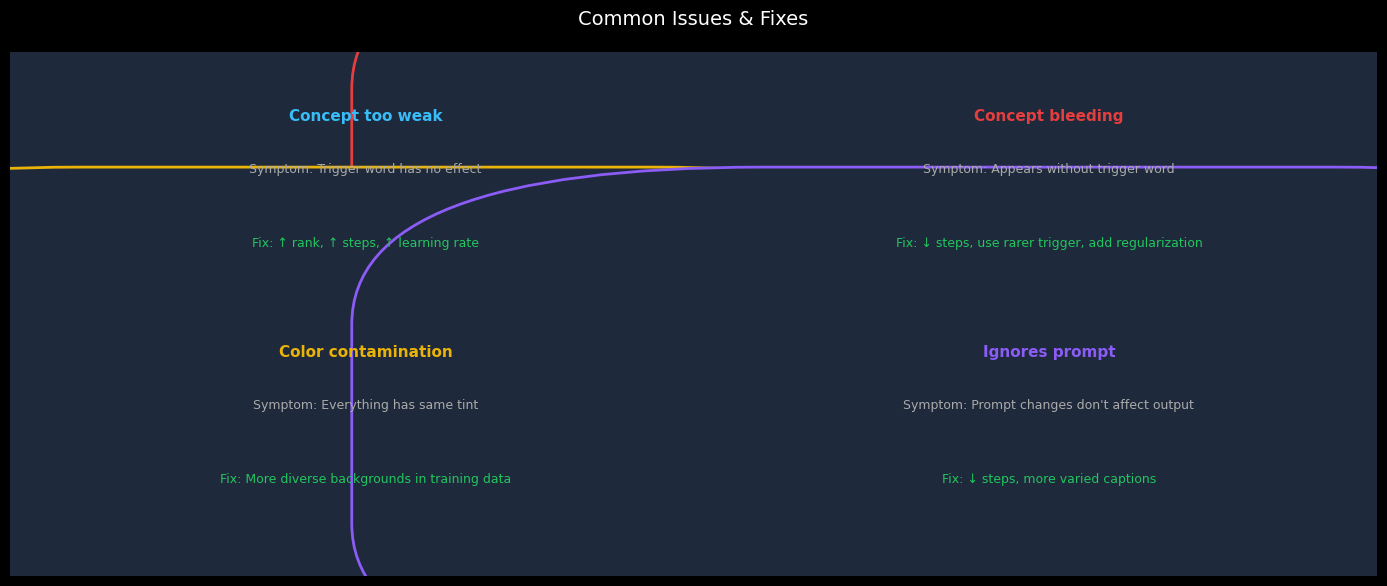

In [8]:
def show_common_issues():
    """Common issues and solutions."""
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    
    issues = [
        ('Concept too weak', 
         'Trigger word has no effect',
         '↑ rank, ↑ steps, ↑ learning rate',
         C['info']),
        ('Concept bleeding',
         'Appears without trigger word',
         '↓ steps, use rarer trigger, add regularization',
         C['lora']),
        ('Color contamination',
         'Everything has same tint',
         'More diverse backgrounds in training data',
         C['warn']),
        ('Ignores prompt',
         'Prompt changes don\'t affect output',
         '↓ steps, more varied captions',
         C['double']),
    ]
    
    for i, (issue, symptom, fix, color) in enumerate(issues):
        x = 0.05 + (i % 2) * 0.5
        y = 0.55 - (i // 2) * 0.45
        
        ax.add_patch(FancyBboxPatch((x, y), 0.42, 0.38, boxstyle="round",
                                     facecolor='#1e293b', edgecolor=color, lw=2,
                                     transform=ax.transAxes))
        ax.text(x+0.21, y+0.32, issue, ha='center', fontsize=11, fontweight='bold',
               color=color, transform=ax.transAxes)
        ax.text(x+0.21, y+0.22, f'Symptom: {symptom}', ha='center', fontsize=9,
               color='#aaa', transform=ax.transAxes)
        ax.text(x+0.21, y+0.08, f'Fix: {fix}', ha='center', fontsize=9,
               color=C['good'], transform=ax.transAxes)
    
    ax.set_title('Common Issues & Fixes', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

show_common_issues()

## Quick Reference

### Starting Configuration for Klein Base 4B

In [9]:
config = """
╔═══════════════════════════════════════════════════════════════╗
║         KLEIN BASE 4B — LORA STARTING POINT                   ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  Model:         black-forest-labs/FLUX.2-klein-base-4B        ║
║  Architecture:  flux2_klein_4b                                ║
║                                                               ║
║  LoRA Settings:                                               ║
║    rank:        32          (16-64 depending on concept)      ║
║    alpha:       32          (typically = rank)                ║
║    targets:     attention + conv layers                       ║
║                                                               ║
║  Training:                                                    ║
║    lr:          1e-4        (can try up to 3e-4)              ║
║    steps:       250-500     (for ~50 images)                  ║
║    batch:       1           (gradient accumulation if needed) ║
║    optimizer:   adamw8bit                                     ║
║    scheduler:   flowmatch                                     ║
║    timestep:    weighted                                      ║
║                                                               ║
║  Data:                                                        ║
║    format:      image + caption.txt (+ control image for i2i) ║
║    resolution:  512, 768, 1024 (multi-res)                    ║
║    captions:    trigger word + description                    ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
"""
print(config)


╔═══════════════════════════════════════════════════════════════╗
║         KLEIN BASE 4B — LORA STARTING POINT                   ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  Model:         black-forest-labs/FLUX.2-klein-base-4B        ║
║  Architecture:  flux2_klein_4b                                ║
║                                                               ║
║  LoRA Settings:                                               ║
║    rank:        32          (16-64 depending on concept)      ║
║    alpha:       32          (typically = rank)                ║
║    targets:     attention + conv layers                       ║
║                                                               ║
║  Training:                                                    ║
║    lr:          1e-4        (can try up to 3e-4)              ║
║    steps:       250-500     (for ~50 images)                  ║
║    batc

---
# Summary

**What we covered:**

1. **Klein Base is ideal for fine-tuning** — undistilled, full capacity, flow matching

2. **Dual-stream architecture** — double blocks for text↔image binding, single blocks for features

3. **LoRA is efficient** — ~1-3M trainable params vs 4B total

4. **500 steps was enough** for our 44-image dataset to learn a clear concept

5. **Diverse captions matter** — same caption everywhere leads to overfitting

**The training samples show the concept emerging around step 200-250, then stabilizing.**

---

*Workshop materials — Black Forest Labs*